# Sigma factors in *Streptomyces albidoflavus*

There are a large number of sigma factors encoded in the *S. albidoflavus* genome. Let's explore how these are expressed across our compendium.

In [1]:
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.io import load_json_model
from pymodulon.plotting import *

from scipy.stats import spearmanr
import numpy as np
import pandas as pd

In [2]:
sns.set_style('ticks')
plt.style.use('custom.mplstyle')

In [3]:
figure_dir = '../../reports/figures/modulome/Fig5'
data_dir = path.join('../..','data','processed', 'modulome')
interim_dir = path.join('../..','data','interim', 'modulome')

In [4]:
data_file = path.join(data_dir,'salb.json.gz')
ica_data = load_json_model(data_file)
gene_info = path.join(data_dir,'merged_gene_info.csv')
gene_info = pd.read_csv(gene_info, index_col=0)
tf_info = path.join(interim_dir,'tf_info.csv')
tf_info = pd.read_csv(tf_info, index_col=0)

sigma_factors_raw = tf_info[tf_info['family'] == 'Sigma']
sigma_factors_raw = sigma_factors_raw.drop(columns=['gene_name','gene_product', 'eggNOG_OGs', 'start', 'end', 'strand', 'operon', 'COG', 'PFAMs'])

sigma_factors = gene_info.merge(sigma_factors_raw, on='locus_tag')

def categorize_sigma(row):
    if pd.isnull(row):
        return 'Uncategorized'
    elif 'Sigma70_r1_2' in row:
        return 'Group 1'
    elif 'Sigma70_r1_2' not in row and all(x in row for x in ['Sigma70_r2', 'Sigma70_r3', 'Sigma70_r4']):
        return 'Group 2'
    elif 'Sigma70_r1_2' not in row and 'Sigma28' in row:
        return 'Group 3'
    elif 'Sigma70_r1_2' not in row and 'Sigma70_r3' not in row and all(x in row for x in ['Sigma70_r2', 'Sigma70_r4']):
        return 'Group 4'
    elif pd.notnull(row):
        return 'Anti-Sigma'
    else:
        return 'Uncategorized'

# Apply the function to the 'PFAMs' column to create the new 'Type' column
sigma_factors['Type'] = sigma_factors['PFAMs'].apply(categorize_sigma)

# Change locus_tags 'XNR_RS12225', 'XNR_RS12230', and 'XNR_RS07520' to Anti-anti-sigma in 'Type'
sigma_factors.loc[sigma_factors['locus_tag'].isin(['XNR_RS12225', 'XNR_RS12230', 'XNR_RS07520']), 'Type'] = 'Anti-anti-Sigma'

gene_info = pd.read_csv('../../data/processed/modulome/merged_gene_info.csv')
tf_info = pd.read_csv('../../data/interim/modulome/tf_info.csv')

tf_list = sigma_factors['locus_tag'].tolist()
df = ica_data.X

In [16]:
# Remove genes with Nan values
df = df.dropna()

# Transpose the DataFrame so that the genes are the columns
df = df.T

correlation_data = []
p_value_data = []

for tf in tf_list:
    # Check if the transcription factor is in the dataframe
    if tf in df.columns:
        tf_expression = df[tf]

        # Check if the expression data contains any invalid values
        if not np.any(np.isnan(tf_expression)) and not np.any(np.isinf(tf_expression)):
            correlation_row = pd.Series(np.nan, index=df.columns)
            p_value_row = pd.Series(np.nan, index=df.columns)
            for gene in df.columns:
                gene_expression = df[gene]
                
                # Check if either array is constant
                if np.std(gene_expression) != 0 and np.std(tf_expression) != 0:
                    correlation, p_value = spearmanr(gene_expression, tf_expression)

                    correlation_row[gene] = correlation
                    p_value_row[gene] = p_value

            correlation_data.append(correlation_row)
            p_value_data.append(p_value_row)

correlation_df = pd.concat(correlation_data, axis=1, keys=tf_list)
p_value_df = pd.concat(p_value_data, axis=1, keys=tf_list)

correlation_df, p_value_df

(                   0         1         2         3         4         5   \
 XNR_RS30570  0.082096  0.489513  0.326133 -0.047426  0.219735  0.143003   
 XNR_RS00005  0.189625  0.379011  0.196601 -0.081365  0.003581 -0.009970   
 XNR_RS00010  0.287551  0.076367  0.138340  0.245578  0.239927  0.415659   
 XNR_RS00015  0.103839 -0.231636  0.216356  0.175432 -0.055542  0.129995   
 XNR_RS00020  0.338465 -0.376710 -0.047451  0.523886 -0.156918 -0.037183   
 ...               ...       ...       ...       ...       ...       ...   
 XNR_RS29420       NaN       NaN       NaN       NaN       NaN       NaN   
 XNR_RS29425       NaN       NaN       NaN       NaN       NaN       NaN   
 XNR_RS29430       NaN       NaN       NaN       NaN       NaN       NaN   
 XNR_RS30650       NaN       NaN       NaN       NaN       NaN       NaN   
 XNR_RS30655       NaN       NaN       NaN       NaN       NaN       NaN   
 
                    6         7         8         9   ...        21        22  \
 XNR_

In [25]:
p_value_df.to_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_p_values.csv')
correlation_df.to_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_correlations.csv')

<Figure size 1500x1500 with 0 Axes>

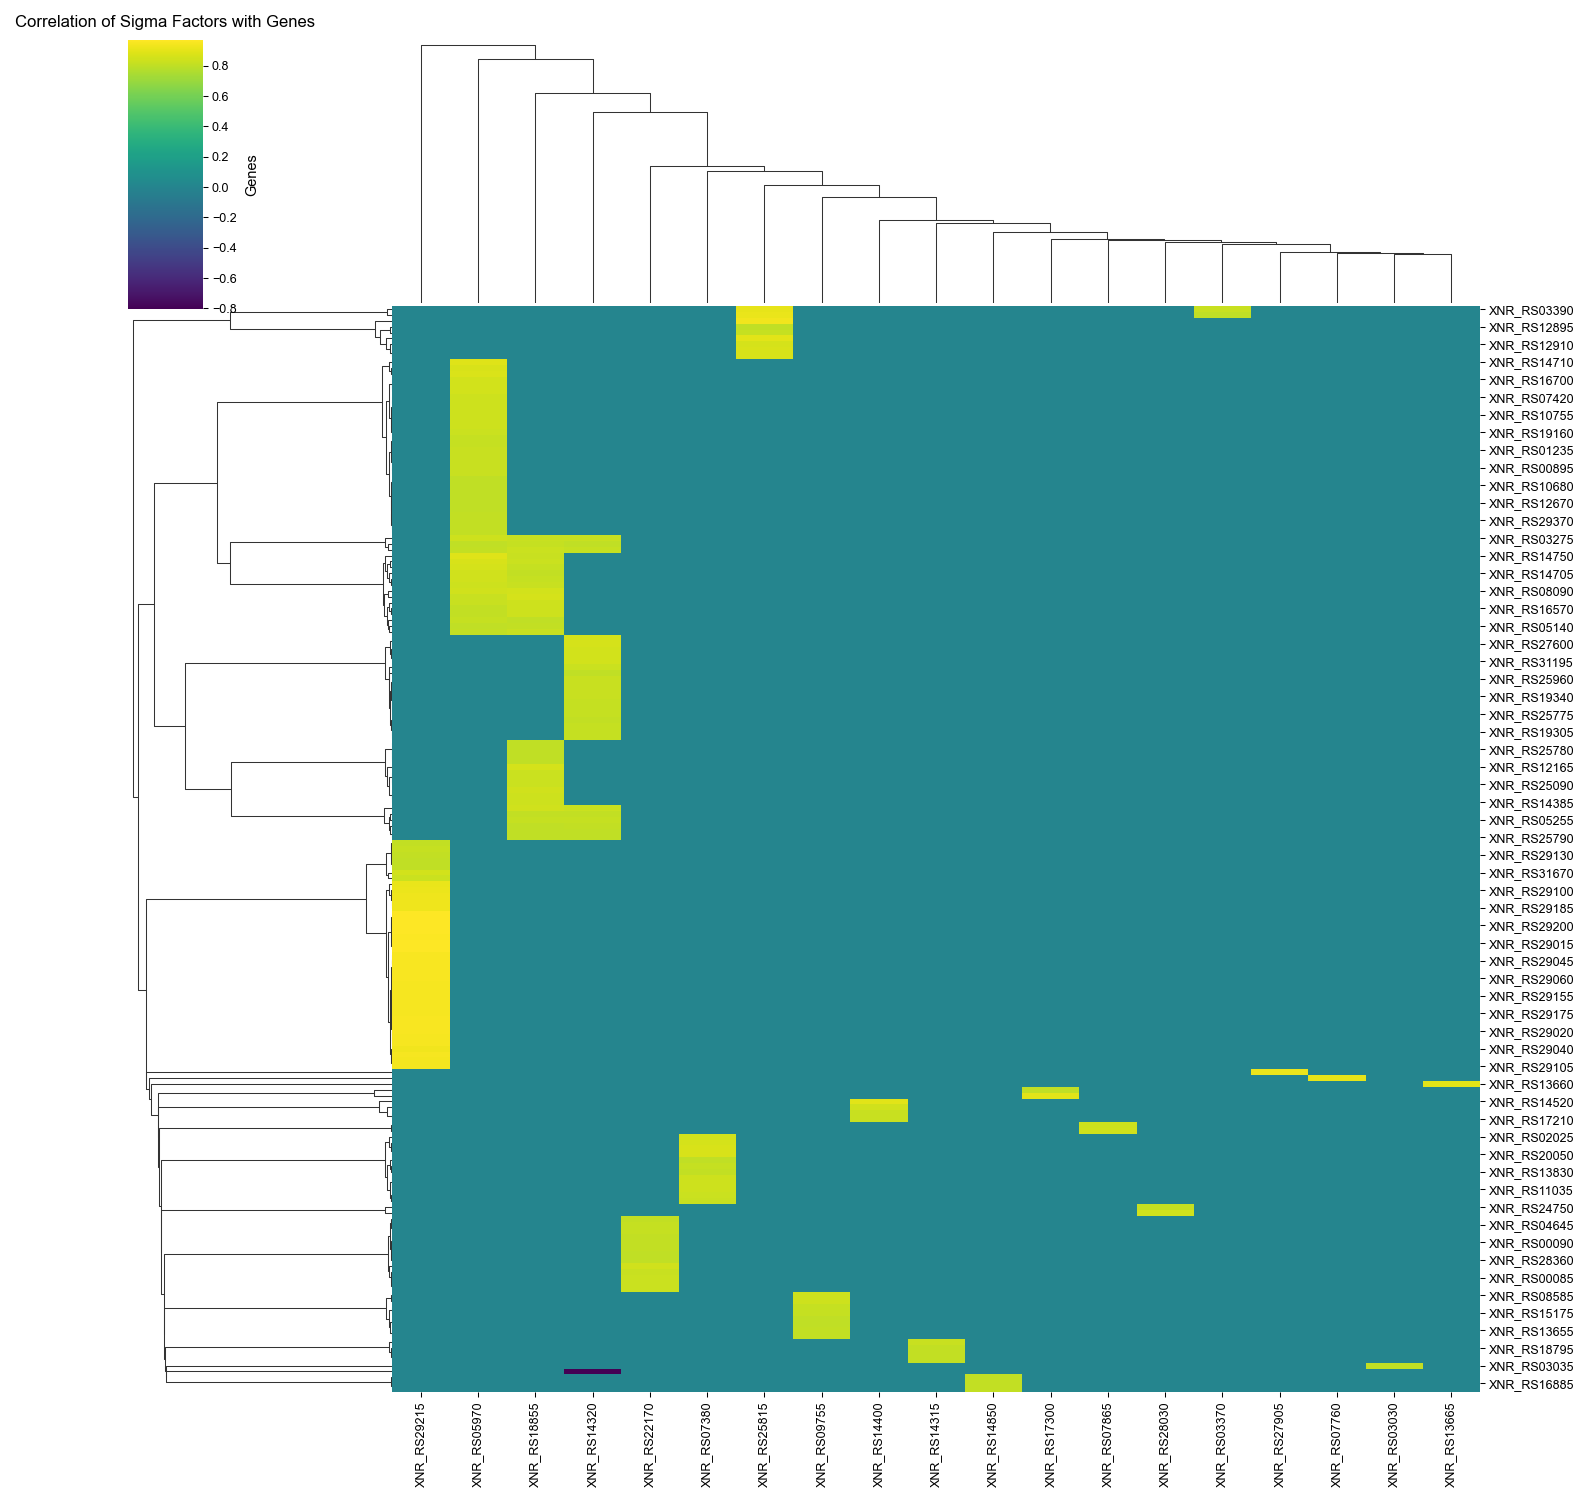

In [9]:
p_value_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_p_values.csv', index_col=0)
correlation_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_correlations.csv', index_col=0)

# filter the tf_correlation to only include the sigma factors in the columns
sigma_correlation = correlation_df

# Fill non-finite values with 0
sigma_correlation = sigma_correlation.fillna(0)

# Remove rows with matching locus tag to the sigma factors
sigma_correlation = sigma_correlation.drop(tf_list, errors='ignore')

# Remove rows where no value is above upr_threshold or below lwr_threshold
upr_threshold = 0.8
lwr_threshold = -0.8
sigma_correlation = sigma_correlation[(sigma_correlation > upr_threshold).any(axis=1) | (sigma_correlation < lwr_threshold).any(axis=1)]

# Create a boolean Series for column filtering
col_filter = (sigma_correlation > upr_threshold).any() | (sigma_correlation < lwr_threshold).any()

# Filter the columns
sigma_correlation = sigma_correlation.loc[:, col_filter]

# Set values between -0.7 and 0.7 to 0
sigma_correlation = sigma_correlation.where((sigma_correlation > 0.8) | (sigma_correlation < -0.8), 0)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.clustermap(sigma_correlation, cmap='viridis')
plt.title('Correlation of Sigma Factors with Genes')
plt.xlabel('Sigma Factors')
plt.ylabel('Genes')
plt.show()

P-values instead

<Figure size 1500x1500 with 0 Axes>

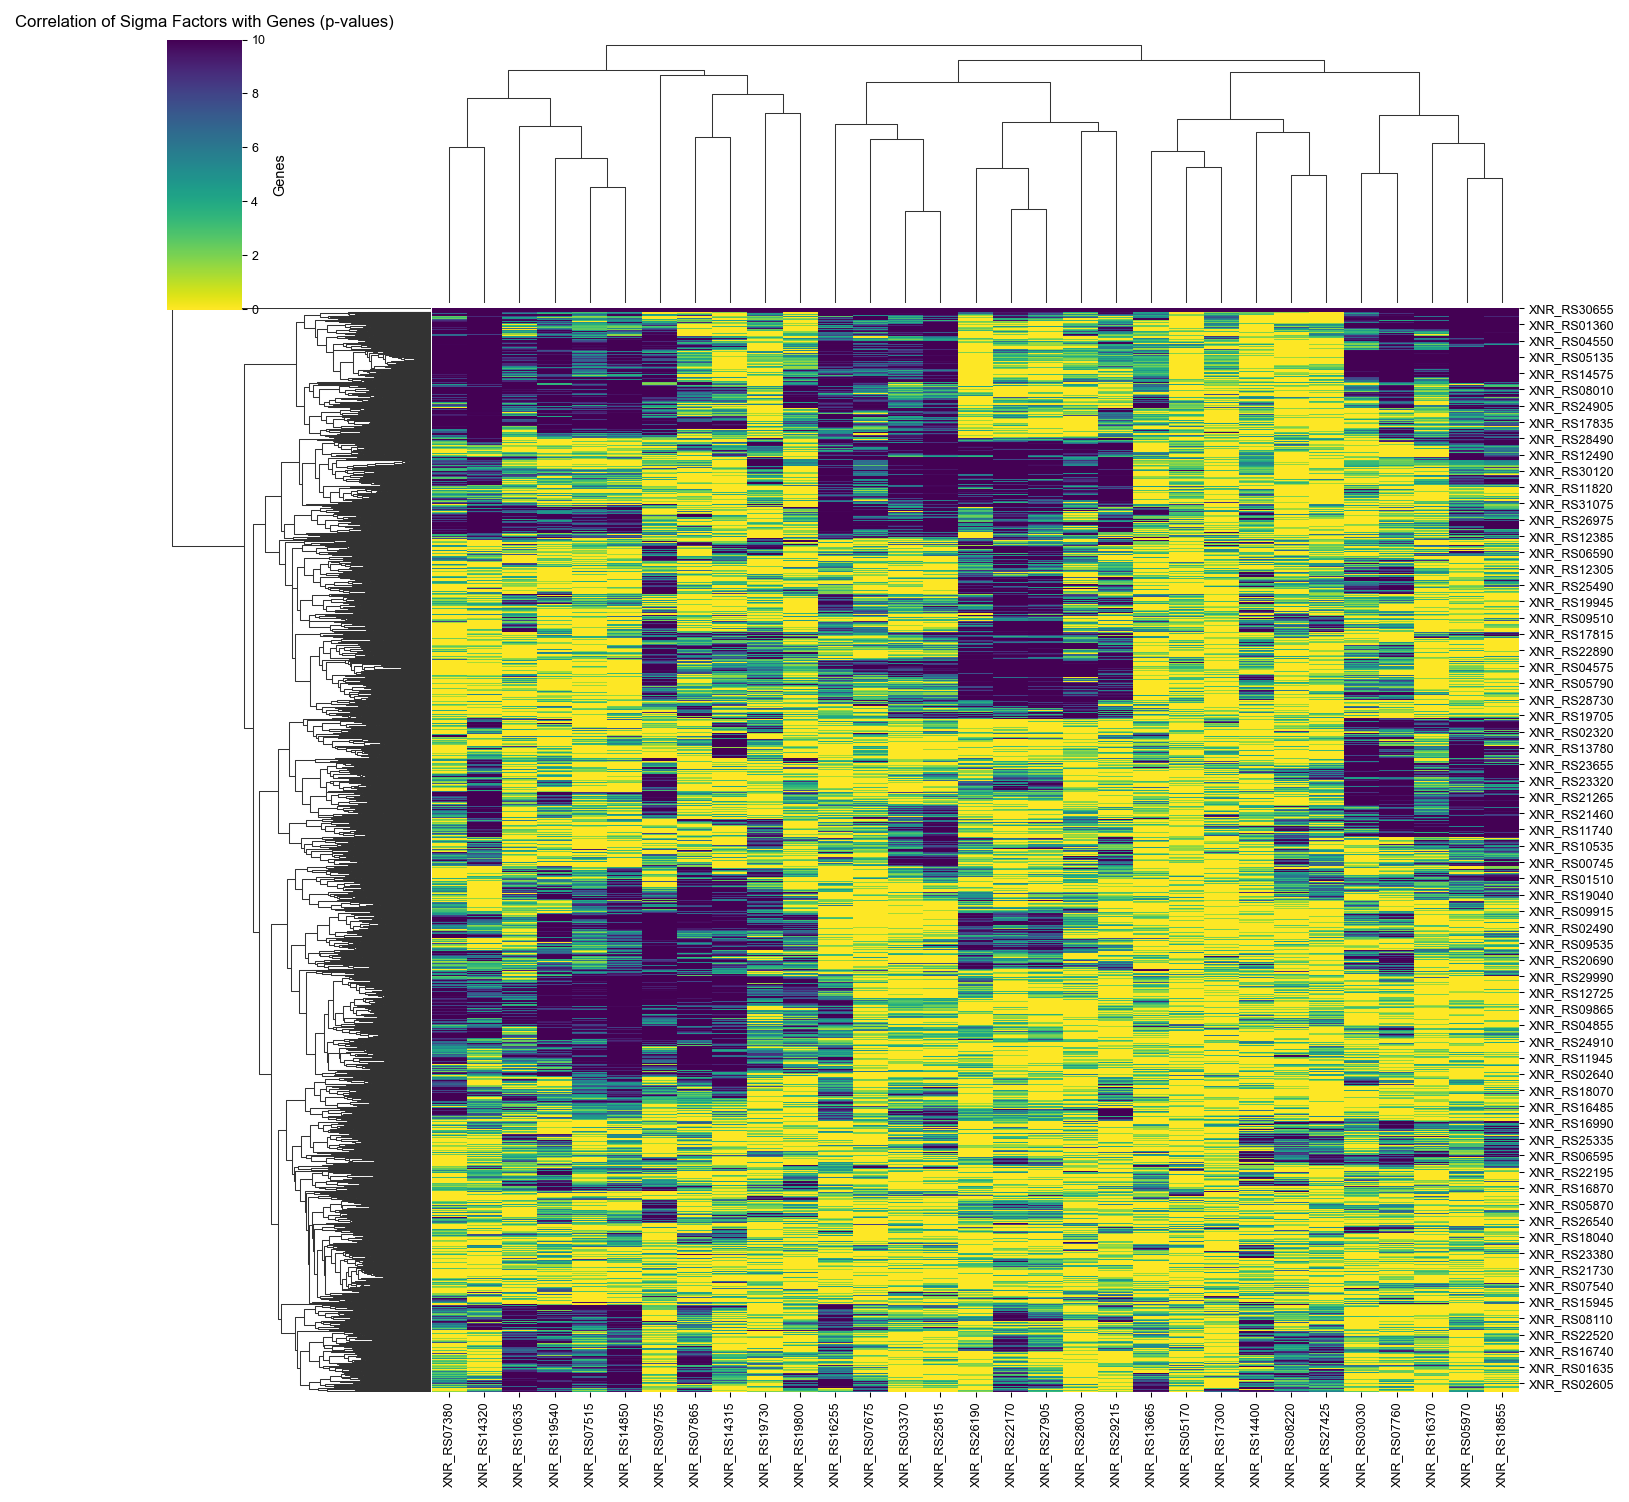

In [14]:
p_value_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_p_values.csv', index_col=0)
correlation_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_correlations.csv', index_col=0)

# filter the tf_correlation to only include the sigma factors in the columns
sigma_correlation = p_value_df

# Fill non-finite values with 0
sigma_correlation = sigma_correlation.fillna(0)

# Remove rows with matching locus tag to the sigma factors
sigma_correlation = sigma_correlation.drop(tf_list, errors='ignore')

# Adjust p-values > 0.05 to 1
sigma_correlation[sigma_correlation > 0.05] = 1

# Add a small constant to avoid taking log of zero
sigma_correlation += 1e-10

# Convert p-values to negative log scale for better visibility
sigma_correlation_log = -np.log10(sigma_correlation)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.clustermap(sigma_correlation_log, cmap='viridis_r')
plt.title('Correlation of Sigma Factors with Genes (p-values)')
plt.xlabel('Sigma Factors')
plt.ylabel('Genes')
plt.show()

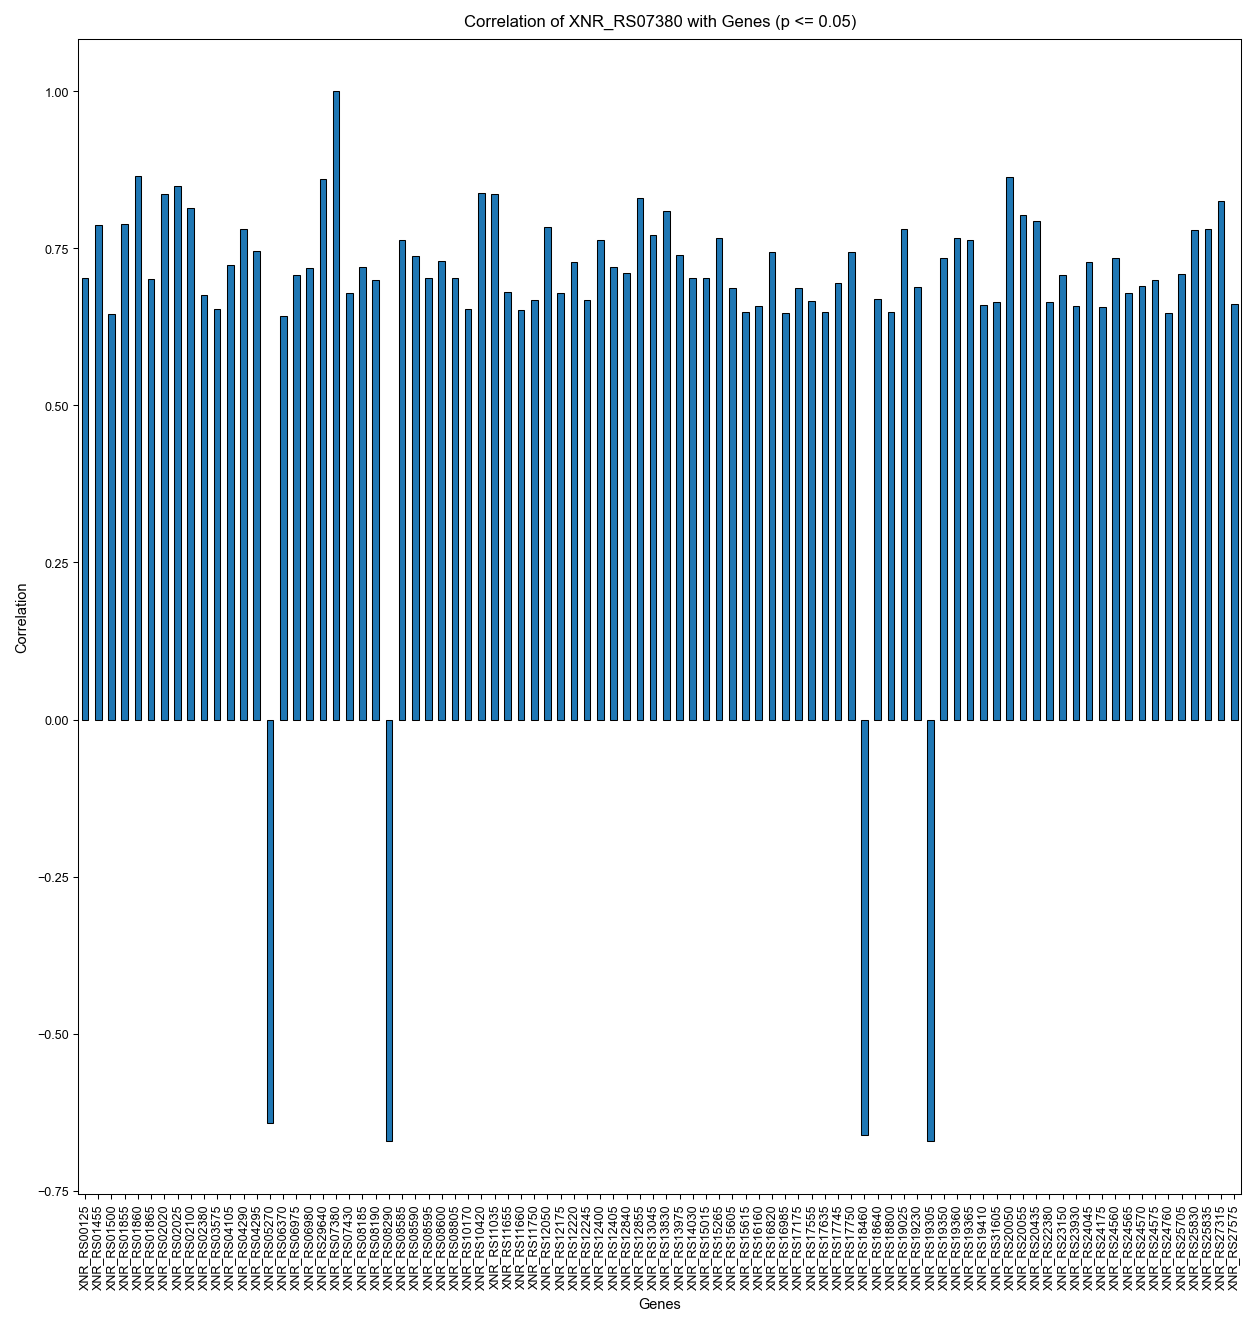

In [27]:
# Choose a sigma factor
sigma_factor = 'XNR_RS07380'  # replace with your sigma factor name

# Get the p-values and correlations for the chosen sigma factor
p_values = p_value_df[sigma_factor]
correlations = correlation_df[sigma_factor]

# Filter for genes with p-value <= 0.05
significant_genes = correlations[p_values <= 0.00000000000000000000000001]

# Create a bar plot
plt.figure(figsize=(10, 10))
significant_genes.plot(kind='bar')
plt.title(f'Correlation of {sigma_factor} with Genes (p <= 0.05)')
plt.xlabel('Genes')
plt.ylabel('Correlation')
plt.show()

In [21]:
significant_genes

XNR_RS30570    0.219735
XNR_RS00010    0.239927
XNR_RS00030    0.192778
XNR_RS00040   -0.221527
XNR_RS00045   -0.298933
                 ...   
XNR_RS29260    0.209149
XNR_RS30980    0.299100
XNR_RS29275   -0.337292
XNR_RS29370   -0.538852
XNR_RS29385    0.222575
Name: XNR_RS07380, Length: 3490, dtype: float64

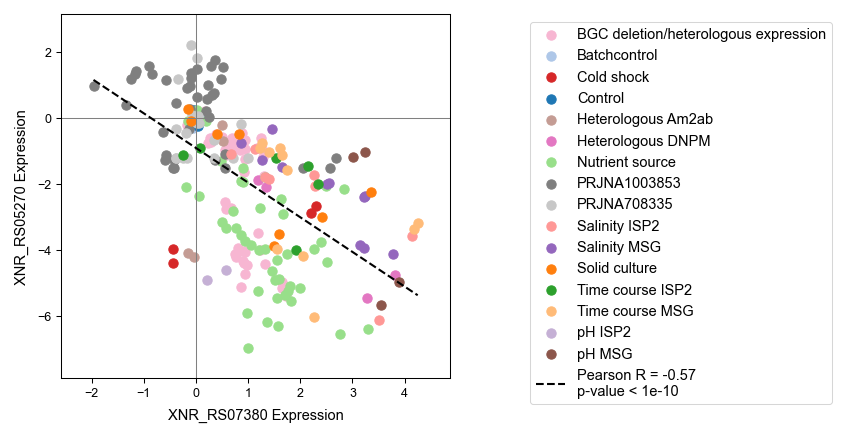

In [29]:
# Convert the page size from mm to inches
width = 85 / 25.4  # ~6.69 inches
height = 80 / 25.4  # ~3.94 inches

fig,ax = plt.subplots(figsize=(width, height))

# Create a dictionary where the keys are the sample IDs and the values are the project names
groups = ica_data.sample_table['project'].to_dict()

# Generate 16 colors from the 'tab20' colormap
colors = plt.cm.tab20(range(16))

compare_expression(ica_data,'XNR_RS07380', 'XNR_RS05270', colors=colors, groups=groups,
                   scatter_kwargs={'s': 20}, ax=ax)

# Increase x and y axis text size
ax.tick_params(axis='both', which='major', labelsize=6)

# Increase the x and y-axis label size
#ax.set_xlabel('Surugamide repressor', fontsize=6)
#ax.set_ylabel('Surugamide', fontsize=6)

# Move the legend to the top right outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

#plt.savefig(path.join(figure_dir,'surugamide_TFs_expr_correlation.svg'))    

# Let's try correlating the sigma factor expression vs imodulon activity

In [30]:
df = ica_data.A
df

,Control1-MSG,Control2-MSG,27-J1074-RNA-Cryo-MM,28-J1074-RNA-Cryo-MM,7_Plate_A_MS,8_Plate_A_MS,10_Plate_B_MS,9_Plate_B_MS,11-J1074-RNA-Plate-Filter2A-MS,12-J1074-RNA-Plate-Filter2A-MS,...,SRX10298355,SRX10298356,SRX10298357,SRX10298358,SRX10298362,SRX10298363,SRX10298364,SRX10298368,SRX10298369,SRX10298370
BGC-19-20 deletion,0.693179,-0.693179,0.736537,-0.614323,-0.102133,-0.685752,1.632810,-0.492989,-0.712772,-0.638632,...,0.534969,0.141625,-0.018626,-1.146266,1.715683,1.941111,3.601585,2.059492,1.927169,1.963556
Glutamine,1.822593,-1.822593,2.091195,-1.308572,12.592783,15.367018,7.935731,11.378277,6.518959,6.753561,...,1.084114,14.688699,14.283839,13.684762,-0.430706,-0.231537,0.370867,-3.247880,-1.110355,-2.434795
Prophages,0.365444,-0.365444,-0.415792,-1.216557,-4.107520,-3.887419,-1.589753,-4.043338,-3.087478,-1.341620,...,-1.021156,-2.202240,0.907447,5.265900,-0.306853,-2.317539,0.485299,1.203519,0.027511,-1.284118
Surugamide repressor,1.520526,-1.520526,0.958160,-1.252034,-11.628200,-10.655149,-1.780417,-0.146843,11.692607,11.646931,...,1.051075,0.334182,-0.787930,-2.912207,4.520793,6.097903,6.872831,2.874169,2.445566,2.213173
ArsR,1.343174,-1.343174,1.715141,-0.787717,-1.573442,0.170682,-0.919929,-0.774946,-1.486323,-2.221335,...,-0.520368,7.015750,7.170277,1.259261,3.434415,11.874656,4.841906,14.048267,10.818453,14.717725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Quorum sensing,1.627195,-1.627195,0.261597,-1.381086,2.601053,2.102630,-10.315253,-11.250289,-11.206467,-11.989168,...,-1.685822,-7.630366,-9.069276,-8.330648,2.228276,3.245239,2.711135,6.004864,4.200487,3.867789
Serine protease,-1.596076,1.596076,-2.328113,1.508253,-2.266079,-6.037653,-4.514760,-5.098739,-11.758951,-11.266267,...,-1.241806,-4.926588,-4.400826,-3.647399,-18.351662,-15.361987,-14.463390,-10.301293,-13.363416,-11.015232
Surugamide,0.407706,-0.407706,0.146947,-1.522333,4.913605,4.368542,2.339356,0.436221,2.096327,1.036687,...,-1.306380,-8.474509,-9.220440,-8.022218,2.110415,2.223643,4.056278,2.731538,1.757358,-1.227190
Amino acid transport,0.802292,-0.802292,-0.391923,-2.580798,-11.363643,-10.853338,-1.936108,-2.900420,-9.976882,-11.535185,...,-1.030260,-2.689914,-4.400202,-4.010526,5.413301,6.002075,8.134723,5.048895,3.787465,3.849603


In [31]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Assuming locus_tags is a list of locus tags
locus_tags = sigma_factors['locus_tag'].tolist()

# Extract the activity scores for each locus tag from ica_data.X
locus_scores = ica_data.X.loc[locus_tags]

# Extract the scores for each imodulon in ica_data.A
imodulon_scores = ica_data.A.T

correlation_data = []
p_value_data = []

for locus in locus_tags:
    # Check if the locus is in the dataframe
    if locus in locus_scores.index:
        locus_expression = locus_scores.loc[locus]

        # Initialize the correlation_row and p_value_row for each locus
        correlation_row = pd.Series(np.nan, index=imodulon_scores.columns)
        p_value_row = pd.Series(np.nan, index=imodulon_scores.columns)

        for imodulon in imodulon_scores.columns:
            imodulon_expression = imodulon_scores[imodulon]

            # Remove rows with NaN values in either dataframe
            combined = pd.concat([locus_expression, imodulon_expression], axis=1)
            combined.dropna(inplace=True)

            locus_expression = combined[locus]
            imodulon_expression = combined[imodulon]

            # Check if either array is constant
            if np.std(imodulon_expression) != 0 and np.std(locus_expression) != 0:
                correlation, p_value = spearmanr(imodulon_expression, locus_expression)

                correlation_row[imodulon] = correlation
                p_value_row[imodulon] = p_value

        correlation_data.append(correlation_row)
        p_value_data.append(p_value_row)
    
correlation_df = pd.concat(correlation_data, axis=1, keys=locus_tags).T
p_value_df = pd.concat(p_value_data, axis=1, keys=locus_tags).T

correlation_df.to_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_imodulons_correlations.csv')
p_value_df.to_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_imodulons_p_values.csv')

In [5]:
correlation_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_imodulons_correlations.csv', index_col=0)
p_value_df = pd.read_csv('../../data/processed/modulome/sigma_factors/spearman_correlation/sigma_factors_imodulons_p_values.csv', index_col=0)

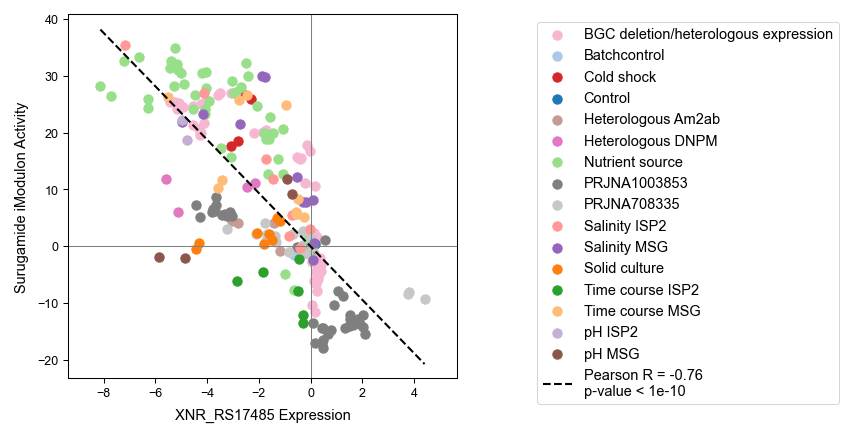

In [16]:
# Convert the page size from mm to inches
width = 85 / 25.4  # ~6.69 inches
height = 80 / 25.4  # ~3.94 inches

fig,ax = plt.subplots(figsize=(width, height))

# Create a dictionary where the keys are the sample IDs and the values are the project names
groups = ica_data.sample_table['project'].to_dict()

# Generate 16 colors from the 'tab20' colormap
colors = plt.cm.tab20(range(16))

compare_imodulon_gene(ica_data, 'Surugamide', 'XNR_RS17485', colors=colors, groups=groups,
                   scatter_kwargs={'s': 20}, ax=ax)

# Increase x and y axis text size
ax.tick_params(axis='both', which='major', labelsize=6)

# Increase the x and y-axis label size
#ax.set_xlabel('Surugamide repressor', fontsize=6)
#ax.set_ylabel('Surugamide', fontsize=6)

# Move the legend to the top right outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

#plt.savefig('../../reports/figures/modulome/Fig3/Sur_repressor_correlation_surA.svg')



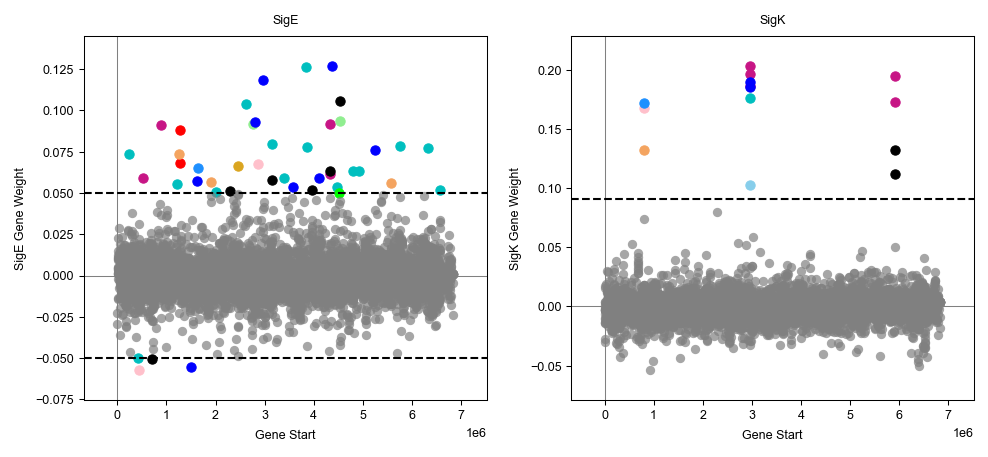

In [16]:
# Set the svg.fonttype parameter to 'none'
plt.rcParams['svg.fonttype'] = 'none'

# Convert the page size from mm to inches
width = 170 / 25.4  # ~6.69 inches
height = 80 / 25.4  # ~3.94 inches

# Define a list of imodulons
imodulons = ['SigE','SigK']

# Create a grid of subplots with two columns
fig, axs = plt.subplots(len(imodulons)//2 + len(imodulons)%2, 2, figsize=(width, height))

# Loop over the subplots and plot the gene weights
for i, ax in enumerate(axs.flat):
    if i < len(imodulons):
        plot_gene_weights(ica_data, imodulons[i], show_labels=False, label_font_kwargs={'fontsize':6}, ax=ax, legend=False, scatter_kwargs={'s': 20})
        ax.set_title(imodulons[i], fontsize=6)

        # Increase x and y axis text size
        ax.tick_params(axis='both', which='major', labelsize=6)

        # Increase x and y axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=6)
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.savefig('../../reports/figures/modulome/Fig5/gene_weights_sigma.svg')
plt.show()

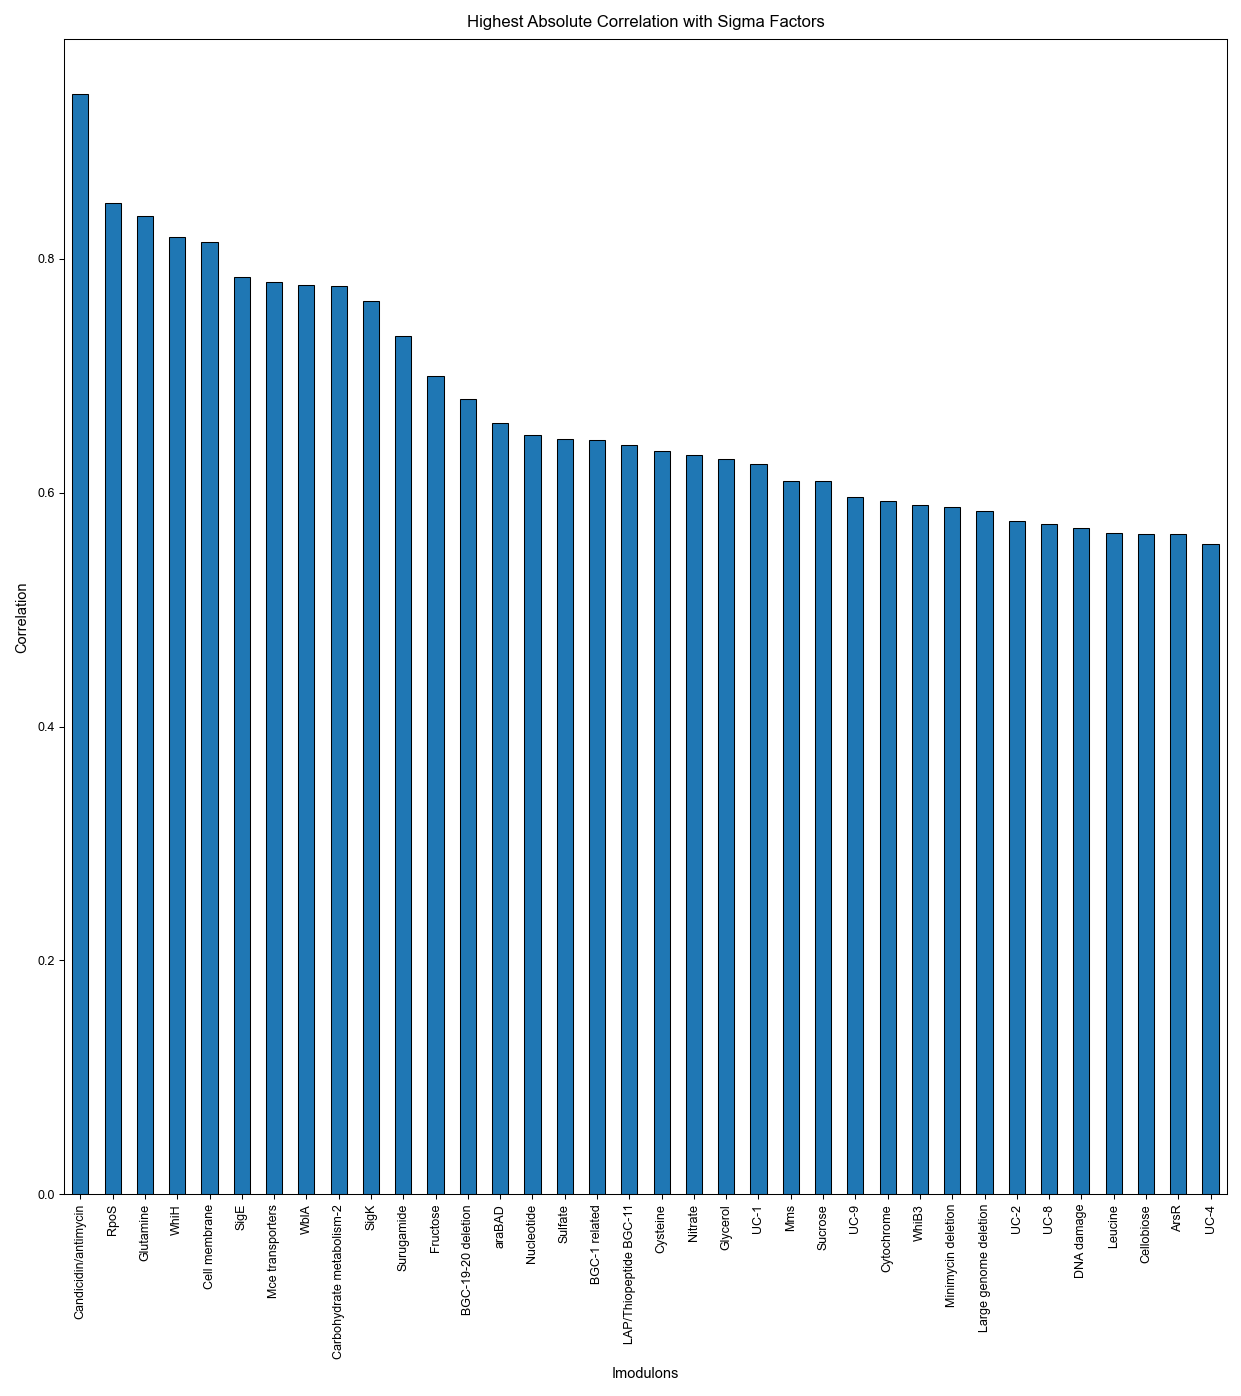

In [9]:
# Make a bar plot plotting the highest absolute value from correlation_df for each imodulon
correlation_max = correlation_df.abs().max()

# remove imodulons with a correlation score < 0.5
correlation_max = correlation_max[correlation_max > 0.55]

# Sort the values in descending order
correlation_max = correlation_max.sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(10, 10))
correlation_max.plot(kind='bar')
plt.title('Highest Absolute Correlation with Sigma Factors')
plt.xlabel('Imodulons')
plt.ylabel('Correlation')
plt.show()

<AxesSubplot:xlabel='XNR_RS12235 Expression', ylabel='XNR_RS19540 Expression'>

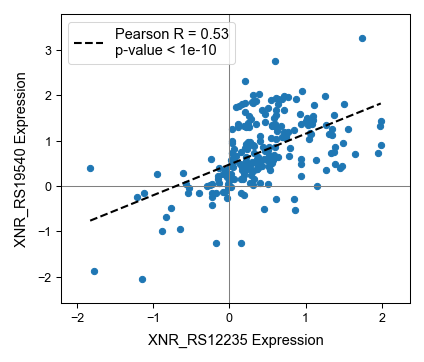

In [84]:
compare_expression(ica_data,'XNR_RS12235', 'XNR_RS19540')

# Network analysis comparing the similarity of activities in both iModulons and sigma factors

In [34]:
ica_data.A

,Control1-MSG,Control2-MSG,27-J1074-RNA-Cryo-MM,28-J1074-RNA-Cryo-MM,7_Plate_A_MS,8_Plate_A_MS,10_Plate_B_MS,9_Plate_B_MS,11-J1074-RNA-Plate-Filter2A-MS,12-J1074-RNA-Plate-Filter2A-MS,...,SRX10298355,SRX10298356,SRX10298357,SRX10298358,SRX10298362,SRX10298363,SRX10298364,SRX10298368,SRX10298369,SRX10298370
BGC-19-20 deletion,0.693179,-0.693179,0.736537,-0.614323,-0.102133,-0.685752,1.632810,-0.492989,-0.712772,-0.638632,...,0.534969,0.141625,-0.018626,-1.146266,1.715683,1.941111,3.601585,2.059492,1.927169,1.963556
Glutamine,1.822593,-1.822593,2.091195,-1.308572,12.592783,15.367018,7.935731,11.378277,6.518959,6.753561,...,1.084114,14.688699,14.283839,13.684762,-0.430706,-0.231537,0.370867,-3.247880,-1.110355,-2.434795
Prophages,0.365444,-0.365444,-0.415792,-1.216557,-4.107520,-3.887419,-1.589753,-4.043338,-3.087478,-1.341620,...,-1.021156,-2.202240,0.907447,5.265900,-0.306853,-2.317539,0.485299,1.203519,0.027511,-1.284118
Surugamide repressor,1.520526,-1.520526,0.958160,-1.252034,-11.628200,-10.655149,-1.780417,-0.146843,11.692607,11.646931,...,1.051075,0.334182,-0.787930,-2.912207,4.520793,6.097903,6.872831,2.874169,2.445566,2.213173
ArsR,1.343174,-1.343174,1.715141,-0.787717,-1.573442,0.170682,-0.919929,-0.774946,-1.486323,-2.221335,...,-0.520368,7.015750,7.170277,1.259261,3.434415,11.874656,4.841906,14.048267,10.818453,14.717725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Quorum sensing,1.627195,-1.627195,0.261597,-1.381086,2.601053,2.102630,-10.315253,-11.250289,-11.206467,-11.989168,...,-1.685822,-7.630366,-9.069276,-8.330648,2.228276,3.245239,2.711135,6.004864,4.200487,3.867789
Serine protease,-1.596076,1.596076,-2.328113,1.508253,-2.266079,-6.037653,-4.514760,-5.098739,-11.758951,-11.266267,...,-1.241806,-4.926588,-4.400826,-3.647399,-18.351662,-15.361987,-14.463390,-10.301293,-13.363416,-11.015232
Surugamide,0.407706,-0.407706,0.146947,-1.522333,4.913605,4.368542,2.339356,0.436221,2.096327,1.036687,...,-1.306380,-8.474509,-9.220440,-8.022218,2.110415,2.223643,4.056278,2.731538,1.757358,-1.227190
Amino acid transport,0.802292,-0.802292,-0.391923,-2.580798,-11.363643,-10.853338,-1.936108,-2.900420,-9.976882,-11.535185,...,-1.030260,-2.689914,-4.400202,-4.010526,5.413301,6.002075,8.134723,5.048895,3.787465,3.849603


In [35]:
imod_activities = ica_data.A.T

#use tf_list to filter ica_data.X
sig_activities = ica_data.X.loc[tf_list].T

# Concatenate the two dataframes
merged = pd.concat([sig_activities, imod_activities], axis=1)

merged


,XNR_RS03030,XNR_RS03370,XNR_RS05170,XNR_RS05970,XNR_RS07195,XNR_RS07380,XNR_RS07515,XNR_RS07520,XNR_RS07755,XNR_RS07760,...,Fatty Acid,Nitrate,Nucleotide,Translation,Cell motility,Quorum sensing,Serine protease,Surugamide,Amino acid transport,UC-9
Control1-MSG,0.129704,0.195663,0.100308,-0.230084,0.259579,-0.035212,0.180395,0.028472,-0.142681,-0.084533,...,1.042619,-1.693906,-0.108248,-0.837017,-2.626661,1.627195,-1.596076,0.407706,0.802292,0.525486
Control2-MSG,-0.129704,-0.195663,-0.100308,0.230084,-0.259579,0.035212,-0.180395,-0.028472,0.142681,0.084533,...,-1.042619,1.693906,0.108248,0.837017,2.626661,-1.627195,1.596076,-0.407706,-0.802292,-0.525486
27-J1074-RNA-Cryo-MM,0.116754,0.382191,-0.168080,-0.212393,0.938381,0.105786,0.463566,0.120488,0.388173,0.174723,...,0.542497,-1.453558,-0.620599,-2.952444,-3.156955,0.261597,-2.328113,0.146947,-0.391923,-1.159961
28-J1074-RNA-Cryo-MM,0.146486,0.058218,-0.469555,0.331301,0.329333,-0.054196,-0.141060,-0.053314,0.533493,0.377178,...,-2.400093,0.360411,-0.794563,-3.925020,2.354721,-1.381086,1.508253,-1.522333,-2.580798,-2.241029
7_Plate_A_MS,1.167443,2.249226,0.497496,0.576481,1.494555,-0.100299,0.567753,-0.460117,0.742681,0.551685,...,5.311895,12.055923,7.915797,-24.492611,-21.580088,2.601053,-2.266079,4.913605,-11.363643,3.209677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX10298363,-0.058759,-0.261425,0.144007,0.038971,-1.013369,-0.381266,-0.637993,-0.723240,-0.671768,-0.407738,...,1.832166,0.827404,-0.551770,-2.704513,-0.584759,3.245239,-15.361987,2.223643,6.002075,0.878363
SRX10298364,0.103616,-1.284548,0.133929,-0.112962,-0.946684,-0.175973,-0.637993,-0.723240,-0.211790,-0.585796,...,3.539622,1.292301,-0.744242,1.463258,-0.112487,2.711135,-14.463390,4.056278,8.134723,1.286840
SRX10298368,0.061359,-1.660300,-0.024181,0.197442,-2.097001,-0.383322,-0.637993,-0.723240,-0.066713,-0.094834,...,2.522208,1.945810,1.987285,6.568682,0.890802,6.004864,-10.301293,2.731538,5.048895,3.594805
SRX10298369,-0.470213,-0.201944,0.094924,0.231619,-0.532528,-0.249432,-0.637993,-0.723240,-0.308899,-0.271960,...,2.910713,2.375972,0.246699,2.767938,-0.508290,4.200487,-13.363416,1.757358,3.787465,1.937817


In [36]:
tf_list

['XNR_RS03030',
 'XNR_RS03370',
 'XNR_RS05170',
 'XNR_RS05970',
 'XNR_RS07195',
 'XNR_RS07380',
 'XNR_RS07515',
 'XNR_RS07520',
 'XNR_RS07755',
 'XNR_RS07760',
 'XNR_RS07865',
 'XNR_RS08220',
 'XNR_RS09750',
 'XNR_RS09755',
 'XNR_RS10635',
 'XNR_RS11170',
 'XNR_RS12225',
 'XNR_RS12230',
 'XNR_RS12235',
 'XNR_RS12240',
 'XNR_RS13405',
 'XNR_RS13410',
 'XNR_RS13665',
 'XNR_RS14315',
 'XNR_RS14320',
 'XNR_RS14400',
 'XNR_RS14455',
 'XNR_RS14850',
 'XNR_RS16255',
 'XNR_RS16370',
 'XNR_RS17300',
 'XNR_RS17485',
 'XNR_RS18855',
 'XNR_RS19540',
 'XNR_RS19730',
 'XNR_RS19800',
 'XNR_RS22170',
 'XNR_RS25810',
 'XNR_RS25815',
 'XNR_RS26190',
 'XNR_RS27425',
 'XNR_RS27905',
 'XNR_RS28030',
 'XNR_RS29215',
 'XNR_RS07675']

In [39]:
# Using same function as for the imodulome
def cosine_similarity_ignore_nan(v1, v2):
    mask = ~np.isnan(v1) & ~np.isnan(v2)
    if not mask.any():
        return np.nan
    v1 = v1[mask]
    v2 = v2[mask]
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# List of column names you're interested in
columns_of_interest = tf_list

# Create a dataframe for the edges
edges = []
for col_interest in columns_of_interest:
    for col in merged.columns:
        if col != col_interest:  # avoid comparing a column with itself
            sim = cosine_similarity_ignore_nan(merged[col_interest], merged[col])
            edges.append([col_interest, col, sim])

edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])

# take the absolute values of the weights
#edges_df['Weight'] = edges_df['Weight'].abs()

# Export the edges to a CSV file
edges_df.to_csv('../../data/processed/modulome/sigma_factors/network.csv', index=False)
edges_df

,Source,Target,Weight
0,XNR_RS03030,XNR_RS03370,0.195398
1,XNR_RS03030,XNR_RS05170,0.135526
2,XNR_RS03030,XNR_RS05970,0.544643
3,XNR_RS03030,XNR_RS07195,0.361234
4,XNR_RS03030,XNR_RS07380,-0.216387
...,...,...,...
5485,XNR_RS07675,Quorum sensing,-0.068872
5486,XNR_RS07675,Serine protease,0.047206
5487,XNR_RS07675,Surugamide,0.417215
5488,XNR_RS07675,Amino acid transport,-0.350981


In [26]:
sigma_factors.to_clipboard()

In [89]:
group_4_count = sigma_factors['Type'].value_counts()['Anti-anti-Sigma']
print(group_4_count)

3


In [71]:
node_table = pd.read_csv('../../data/processed/modulome/sigma_factors/node_table.csv')

# Add the Type column from sigma_factors to the node_table
node_table = node_table.merge(sigma_factors[['locus_tag', 'Type']], how='left', left_on='name', right_on='locus_tag')

# Drop the duplicate locus_tag column
node_table = node_table.drop(columns='locus_tag')

# if Type is NaN, set it to 'iModulon'
node_table['Type'] = node_table['Type'].fillna('iModulon')

In [72]:
node_table.to_csv('../../data/processed/modulome/sigma_factors/node_table.csv', index=False)

## How many sigma factors are significantly correlated to at least one imodulon?

In [91]:
# Create a boolean mask where True indicates the value is less than 0.00001
mask = p_value_df.iloc[:, 1:] < 0.00001

# Apply the any() function to the mask along the columns axis
significant_genes = mask.any(axis=1)

# Print the genes that are significantly correlated with at least one imodulon
print(p_value_df[significant_genes]['BGC-19-20 deletion'])

XNR_RS03030    9.798129e-02
XNR_RS03370    3.674946e-06
XNR_RS05170    2.287392e-03
XNR_RS05970    1.088222e-01
XNR_RS07195    1.540415e-04
XNR_RS07380    8.977264e-03
XNR_RS07515    7.903121e-01
XNR_RS07520    9.653925e-01
XNR_RS07755    1.871900e-03
XNR_RS07760    1.579449e-02
XNR_RS07865    6.187054e-04
XNR_RS08220    4.377950e-01
XNR_RS09750    1.532099e-05
XNR_RS09755    1.373444e-15
XNR_RS10635    2.269775e-02
XNR_RS11170    1.446506e-03
XNR_RS12225    4.322612e-01
XNR_RS12230    6.082380e-01
XNR_RS12235    7.641487e-01
XNR_RS12240    2.211107e-01
XNR_RS13405    3.069539e-08
XNR_RS13410    1.651439e-01
XNR_RS13665    1.148454e-01
XNR_RS14315    5.120981e-16
XNR_RS14320    5.076013e-02
XNR_RS14400    8.228041e-04
XNR_RS14455    1.419360e-01
XNR_RS14850    6.289844e-04
XNR_RS16255    2.297833e-01
XNR_RS16370    6.733281e-01
XNR_RS17300    1.302445e-01
XNR_RS17485    5.001261e-01
XNR_RS18855    5.953440e-01
XNR_RS19540    7.804817e-01
XNR_RS19730    6.352523e-08
XNR_RS19800    9.165

# Identify names based on S. coelicolor blast results.

In [24]:
# Load the BBH results
bbh = pd.read_csv('../../data/external/modulome/compare_ica_multi/bbh/salb_prot_vs_Sco_prot_parsed.csv')

# filter the gene column using the sigma factors
bbh = bbh[bbh['gene'].isin(tf_list)]

# parse the Sco.gbff file to get the gene names
sco_gbff = '../../data/external/modulome/genomes/Sco.gbff'

from Bio import SeqIO

# Parse the .gbff file
records = SeqIO.parse(sco_gbff, "genbank")

# Create a dictionary to map locus tags to gene names
locus_to_gene = {}

# Iterate over the records in the .gbff file
for record in records:
    for feature in record.features:
        if feature.type == "CDS":
            locus_tag = feature.qualifiers.get("locus_tag", [None])[0]
            gene_name = feature.qualifiers.get("gene_synonym", [None])[0]
            if locus_tag and gene_name:
                locus_to_gene[locus_tag] = gene_name

# Add a new column to the bbh DataFrame with the gene names
bbh['name'] = bbh['subject'].map(locus_to_gene)

bbh.to_csv('../../data/processed/modulome/sigma_factors/salb_sco_bbh.csv', index=False)